# Graph Neural Network for Human vs LLM Code Classification

This notebook implements a GAT to distinguish between human-written and LLM-generated Python code using Abstract Syntax Tree (AST) representations.

## 1. Setup and Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# Import custom modules
from graphdataset import CodeGraphDataset
from process import PythonCodeProcessor

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration - Support Apple M1/M2 (MPS), CUDA, and CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Using device: {device} (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using device: {device} (NVIDIA GPU)")
else:
    device = torch.device('cpu')
    print(f"Using device: {device} (CPU)")

Using device: mps (Apple Silicon GPU)


## 2. Data Loading and Exploration

In [ ]:
# Configuration
DATA_DIR = 'dataset/python'
VALID_FILE = os.path.join(DATA_DIR, 'valid_no_comment.jsonl')
TEST_FILE = os.path.join(DATA_DIR, 'test_no_comment.jsonl')

MAX_NODES = 500  # Maximum nodes in AST
EMBEDDING_SIZE = 128  # Dimension of node embeddings
BATCH_SIZE = 16  # OPTIMIZED: Can increase to 32 if you have more RAM (faster training)
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
HIDDEN_DIM = 256
NUM_LAYERS = 4
NUM_HEADS = 4  # Reduced from 8 to save memory (can increase if you have more RAM)
DROPOUT = 0.5
WEIGHT_DECAY = 1e-4  # L2 regularization

RESULTS_DIR = 'GAT-results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# NEW: Optimization parameters
MAX_SAMPLES_TRAIN = 5002  # Limit training samples (None = all)
MAX_SAMPLES_TEST = 1001   # Limit test samples (None = all)
TIMEOUT_MINUTES = 200      # Stop processing after 10 minutes

print("Configuration:")
print(f"  Max nodes: {MAX_NODES}")
print(f"  Embedding size: {EMBEDDING_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  GAT layers: {NUM_LAYERS}")
print(f"  Number of heads: {NUM_HEADS}")
print(f"  Dropout: {DROPOUT}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Results dir: {RESULTS_DIR}")
print(f"  Max training samples: {MAX_SAMPLES_TRAIN}")
print(f"  Max test samples: {MAX_SAMPLES_TEST}")
print(f"  Timeout: {TIMEOUT_MINUTES} minutes")



Configuration:
  Max nodes: 500
  Embedding size: 128
  Batch size: 16
  Learning rate: 0.001
  Epochs: 30
  Hidden dim: 256
  GAT layers: 4
  Number of heads: 4
  Dropout: 0.5
  Weight decay: 0.0001
  Max training samples: 5002
  Max test samples: 1001
  Timeout: 200 minutes


In [4]:
# Load datasets with limits and timeout
print("\n" + "="*70)
print("Loading validation dataset...")
print("="*70)
valid_dataset = CodeGraphDataset(
    jsonl_path=VALID_FILE,
    max_nodes=MAX_NODES,
    embedding_size=EMBEDDING_SIZE,
    force_reprocess=False,
    max_samples=MAX_SAMPLES_TRAIN,  # LIMIT SAMPLES
    timeout_minutes=TIMEOUT_MINUTES  # TIMEOUT
)

print("\n" + "="*70)
print("Loading test dataset (sharing vocabulary)...")
print("="*70)
test_dataset = CodeGraphDataset(
    jsonl_path=TEST_FILE,
    processor=valid_dataset.processor,  # Share vocabulary
    max_nodes=MAX_NODES,
    force_reprocess=False,
    max_samples=MAX_SAMPLES_TEST,  # LIMIT SAMPLES
    timeout_minutes=TIMEOUT_MINUTES  # TIMEOUT
)

print(f"\n{'='*70}")
print(f"Validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"{'='*70}")


Loading validation dataset...
Loading cached graphs from dataset/python/cached_graphs/valid_no_comment_n5002_graphs.pkl
Loaded 4907 cached examples
Vocabulary size: 11424

Loading test dataset (sharing vocabulary)...
Loading cached graphs from dataset/python/cached_graphs/test_no_comment_n1001_graphs.pkl
Loaded 972 cached examples
Vocabulary size: 11424

Validation set size: 4907
Test set size: 972


In [5]:
# Display dataset statistics
print("\n" + "="*70)
print("VALIDATION DATASET STATISTICS")
print("="*70)
valid_stats = valid_dataset.get_stats()
for key, value in valid_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

print("\n" + "="*70)
print("TEST DATASET STATISTICS")
print("="*70)
test_stats = test_dataset.get_stats()
for key, value in test_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")


VALIDATION DATASET STATISTICS
total_samples: 4907
avg_code_nodes: 43.49
max_code_nodes: 490
min_code_nodes: 3
avg_contrast_nodes: 43.07
max_contrast_nodes: 424
min_contrast_nodes: 3
label_distribution: {'label_0': 2469, 'label_1': 2438}

TEST DATASET STATISTICS
total_samples: 972
avg_code_nodes: 41.00
max_code_nodes: 476
min_code_nodes: 3
avg_contrast_nodes: 41.13
max_contrast_nodes: 347
min_contrast_nodes: 3
label_distribution: {'label_0': 477, 'label_1': 495}


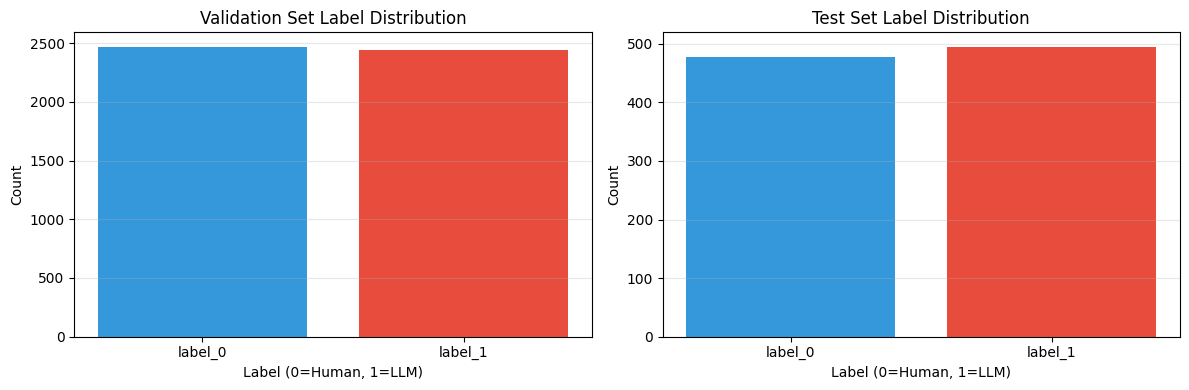

In [ ]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Validation set
valid_labels = valid_stats['label_distribution']
axes[0].bar(valid_labels.keys(), valid_labels.values(), color=['#3498db', '#e74c3c'])
axes[0].set_title('Validation Set Label Distribution')
axes[0].set_xlabel('Label (0=Human, 1=LLM)')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Test set
test_labels = test_stats['label_distribution']
axes[1].bar(test_labels.keys(), test_labels.values(), color=['#3498db', '#e74c3c'])
axes[1].set_title('Test Set Label Distribution')
axes[1].set_xlabel('Label (0=Human, 1=LLM)')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'label_distribution_GAT.png'), dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# Examine a sample
sample = valid_dataset[0]
print("\n" + "="*70)
print("SAMPLE DATA POINT")
print("="*70)
print(f"Index: {sample['index']}")
print(f"Label: {sample['label'].item()} ({'Human' if sample['label'].item() == 0 else 'LLM'})")
print(f"\nCode Graph:")
print(f"  Shape: {sample['code_graph'].shape}")
print(f"  Number of nodes: {sample['code_num_nodes']}")
print(f"  Sequence length: {len(sample['code_sequence'])}")
print(f"  First 15 tokens: {sample['code_sequence'][:15]}")
print(f"\nContrast Graph:")
print(f"  Shape: {sample['contrast_graph'].shape}")
print(f"  Number of nodes: {sample['contrast_num_nodes']}")
print(f"  Sequence length: {len(sample['contrast_sequence'])}")
print(f"  First 15 tokens: {sample['contrast_sequence'][:15]}")


SAMPLE DATA POINT
Index: gp266290
Label: 1 (LLM)

Code Graph:
  Shape: torch.Size([500, 500])
  Number of nodes: 13
  Sequence length: 13
  First 15 tokens: [7, 6, 5, 1, 4, 3, 1, 0, 1, 0, 8, 1, 0]

Contrast Graph:
  Shape: torch.Size([500, 500])
  Number of nodes: 60
  Sequence length: 60
  First 15 tokens: [7, 6, 12, 3, 2, 1, 0, 0, 3, 2, 4587, 0, 1, 0, 5]


In [8]:
# Get embedding matrix
embedding_matrix = valid_dataset.get_embedding_matrix()
print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")
print(f"Vocabulary size: {embedding_matrix.shape[0] - 1}")


Embedding matrix shape: torch.Size([11425, 128])
Vocabulary size: 11424


## 3. GAT Model Architecture

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GATLayer(nn.Module):
    """Optimized Graph Attention Network Layer with parallel head processing.
    
    Key optimizations:
    - Process all heads in parallel using batched operations
    - Reduced NaN checks (only at critical points)
    - More efficient masking operations
    """
    def __init__(self, input_dim, output_dim, num_heads=8, dropout=0.6, concat=True):
        super(GATLayer, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.concat = concat
        self.dropout = dropout
        
        # If concatenating heads, each head outputs output_dim/num_heads features
        if concat:
            assert output_dim % num_heads == 0, "output_dim must be divisible by num_heads when concat=True"
            self.head_dim = output_dim // num_heads
        else:
            self.head_dim = output_dim
        
        # OPTIMIZED: Single linear layer for all heads (batched)
        # Shape: [input_dim, num_heads * head_dim]
        self.W = nn.Linear(input_dim, num_heads * self.head_dim, bias=False)
        nn.init.xavier_uniform_(self.W.weight, gain=1.414)
        
        # Attention mechanism parameters (a^T [Wh_i || Wh_j])
        # Single parameter for all heads: [num_heads, 2 * head_dim, 1]
        self.a = nn.Parameter(torch.zeros(size=(num_heads, 2 * self.head_dim, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.layer_norm = nn.LayerNorm(output_dim)
    
    def forward(self, x, adj, node_mask=None):
        """
        Args:
            x: Node features [batch_size, num_nodes, input_dim]
            adj: Adjacency matrix [batch_size, num_nodes, num_nodes]
            node_mask: Optional mask for valid nodes [batch_size, num_nodes] (1 for valid, 0 for padding)
        
        Returns:
            Updated node features [batch_size, num_nodes, output_dim]
        """
        batch_size, num_nodes, _ = x.size()
        
        # Add self-loops to adjacency matrix
        identity = torch.eye(num_nodes, device=adj.device, dtype=adj.dtype).unsqueeze(0)
        adj_with_self_loops = (adj + identity).clamp(0, 1)
        
        # Create node mask if not provided
        if node_mask is None:
            node_mask = torch.ones(batch_size, num_nodes, device=x.device)
        
        # OPTIMIZED: Process all heads in parallel
        # Linear transformation: [batch, nodes, num_heads * head_dim]
        h = self.W(x)  # [batch, nodes, num_heads * head_dim]
        
        # Reshape to separate heads: [batch, nodes, num_heads, head_dim]
        h = h.view(batch_size, num_nodes, self.num_heads, self.head_dim)
        
        # Split attention vector a into a_l and a_r for all heads
        # a_l: [num_heads, head_dim, 1], a_r: [num_heads, head_dim, 1]
        a_l = self.a[:, :self.head_dim, :]  # [num_heads, head_dim, 1]
        a_r = self.a[:, self.head_dim:, :]  # [num_heads, head_dim, 1]
        
        # Compute attention scores for all heads in parallel
        # h: [batch, nodes, num_heads, head_dim]
        # a_l: [num_heads, head_dim, 1] -> squeeze to [num_heads, head_dim]
        # h_l: [batch, nodes, num_heads]
        h_l = torch.einsum('bnhi,hi->bnh', h, a_l.squeeze(-1))  # [batch, nodes, num_heads]
        h_r = torch.einsum('bnhi,hi->bnh', h, a_r.squeeze(-1))  # [batch, nodes, num_heads]
        
        # Broadcast to get all pairs: [batch, nodes, nodes, num_heads]
        e = h_l.unsqueeze(2) + h_r.unsqueeze(1)  # [batch, nodes, nodes, num_heads]
        e = self.leakyrelu(e)
        
        # Create attention mask: [batch, nodes, nodes, 1]
        valid_mask = (node_mask.unsqueeze(1) * node_mask.unsqueeze(2)).unsqueeze(-1)
        adj_mask = adj_with_self_loops.unsqueeze(-1) * valid_mask
        
        # Mask out non-adjacent or invalid nodes
        e = e.masked_fill(adj_mask == 0, float('-inf'))
        
        # OPTIMIZED: Handle isolated nodes more efficiently
        # For each node, if all attention scores are -inf, set self-attention to 0
        # isolated: [batch, nodes, 1, num_heads] - True if all neighbors are -inf
        isolated = (e == float('-inf')).all(dim=2, keepdim=True)  # [batch, nodes, 1, num_heads]
        # Create self-attention mask: [batch, nodes, nodes, num_heads]
        eye_mask = torch.eye(num_nodes, device=e.device, dtype=e.dtype).unsqueeze(0).unsqueeze(-1)  # [1, nodes, nodes, 1]
        eye_mask = eye_mask.expand(batch_size, -1, -1, self.num_heads)  # [batch, nodes, nodes, num_heads]
        # Set self-attention to 0 for isolated nodes
        e = torch.where(isolated.expand(-1, -1, num_nodes, -1), eye_mask * 0.0, e)
        
        # Apply softmax: [batch, nodes, nodes, num_heads]
        attention = F.softmax(e, dim=2)
        
        # Zero out attention for padding nodes
        attention = attention * adj_mask
        
        # Renormalize (prevent division issues)
        attention_sum = attention.sum(dim=2, keepdim=True).clamp(min=1e-8)
        attention = attention / attention_sum
        
        # Apply dropout
        attention = F.dropout(attention, p=self.dropout, training=self.training)
        
        # Apply attention to features: [batch, nodes, num_heads, head_dim]
        # h: [batch, nodes, num_heads, head_dim]
        # attention: [batch, nodes, nodes, num_heads]
        # Output: [batch, nodes, num_heads, head_dim]
        # Use einsum to apply attention per head in parallel
        # attention: [batch, nodes, nodes, num_heads] -> permute to [batch, num_heads, nodes, nodes]
        # h: [batch, nodes, num_heads, head_dim] -> permute to [batch, num_heads, nodes, head_dim]
        attention_perm = attention.permute(0, 3, 1, 2)  # [batch, num_heads, nodes, nodes]
        h_perm = h.permute(0, 2, 1, 3)  # [batch, num_heads, nodes, head_dim]
        # Apply attention: [batch, num_heads, nodes, nodes] @ [batch, num_heads, nodes, head_dim]
        h_prime = torch.einsum('bhnm,bhmd->bhnd', attention_perm, h_perm)  # [batch, num_heads, nodes, head_dim]
        # Permute back: [batch, nodes, num_heads, head_dim]
        h_prime = h_prime.permute(0, 2, 1, 3)  # [batch, nodes, num_heads, head_dim]
        
        # Zero out features for padding nodes
        h_prime = h_prime * node_mask.unsqueeze(-1).unsqueeze(-1)
        
        # Concatenate or average heads
        if self.concat:
            # Concatenate: [batch, nodes, num_heads * head_dim]
            out = h_prime.reshape(batch_size, num_nodes, self.num_heads * self.head_dim)
        else:
            # Average: [batch, nodes, head_dim]
            out = h_prime.mean(dim=2)
        
        # Apply layer normalization
        out = self.layer_norm(out)
        
        # Zero out padding nodes after normalization
        out = out * node_mask.unsqueeze(-1)
        
        return F.elu(out)


class GATNetwork(nn.Module):
    """Graph Attention Network for code classification."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, 
                 num_classes=2, num_heads=8, dropout=0.3, pretrained_embeddings=None):
        super(GATNetwork, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Token embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
        
        # GAT layers
        self.gat_layers = nn.ModuleList()
        
        # First layer
        self.gat_layers.append(
            GATLayer(embedding_dim, hidden_dim, num_heads=num_heads, 
                    dropout=dropout, concat=True)
        )
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.gat_layers.append(
                GATLayer(hidden_dim, hidden_dim, num_heads=num_heads,
                        dropout=dropout, concat=True)
            )
        
        # Readout MLP (for graph-level classification)
        self.readout = nn.Sequential(
            nn.Linear(hidden_dim * num_layers, hidden_dim),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, sequences, adj_matrices, num_nodes_list):
        """
        Args:
            sequences: LIST of token sequences (Python lists!)
            adj_matrices: Adjacency matrices [batch_size, max_nodes, max_nodes]
            num_nodes_list: List of actual number of nodes
        
        Returns:
            logits: [batch_size, num_classes]
        """
        batch_size = adj_matrices.size(0)
        max_nodes = adj_matrices.size(1)
        
        # Create node mask for valid nodes (1 for valid, 0 for padding)
        node_mask = torch.zeros(batch_size, max_nodes, device=adj_matrices.device)
        for i, num_nodes in enumerate(num_nodes_list):
            node_mask[i, :num_nodes] = 1.0
        
        # Convert list of sequences to padded tensor
        node_features = torch.zeros(batch_size, max_nodes, dtype=torch.long, 
                                    device=adj_matrices.device)
        
        for i, seq in enumerate(sequences):
            num_nodes = num_nodes_list[i]
            seq_len = min(len(seq), num_nodes)
            seq_tensor = torch.tensor(seq[:seq_len], dtype=torch.long, 
                                     device=adj_matrices.device)
            if seq_len < num_nodes:
                padding = torch.zeros(num_nodes - seq_len, dtype=torch.long, 
                                     device=adj_matrices.device)
                seq_tensor = torch.cat([seq_tensor, padding])
            node_features[i, :num_nodes] = seq_tensor
        
        # Embed tokens
        x = self.embedding(node_features)
        
        # Apply GAT layers with node mask
        layer_outputs = []
        for layer in self.gat_layers:
            x = layer(x, adj_matrices, node_mask=node_mask)
            x = F.dropout(x, p=self.dropout, training=self.training)
            layer_outputs.append(x)
        
        # Graph-level readout with masking
        graph_representations = []
        for layer_out in layer_outputs:
            # Use mean pooling instead of sum for better stability
            mask = node_mask.unsqueeze(-1)  # [batch, nodes, 1]
            masked_out = layer_out * mask
            node_counts = node_mask.sum(dim=1, keepdim=True).clamp(min=1)  # [batch, 1]
            graph_rep = masked_out.sum(dim=1) / node_counts  # Mean pooling
            graph_representations.append(graph_rep)
        
        # Concatenate and classify
        graph_rep = torch.cat(graph_representations, dim=1)
        logits = self.readout(graph_rep)
        
        return logits


class SiameseGAT(nn.Module):
    """Siamese network for comparing code using GAT."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                 num_classes=2, num_heads=8, dropout=0.3, pretrained_embeddings=None):
        super(SiameseGAT, self).__init__()
        
        # Shared GAT encoder
        self.gat = GATNetwork(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_classes=hidden_dim * num_layers,
            num_heads=num_heads,
            dropout=dropout,
            pretrained_embeddings=pretrained_embeddings
        )
        
        # Classifier on combined representations
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * num_layers * 2, hidden_dim),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, code_seq, code_adj, code_num_nodes,
                contrast_seq, contrast_adj, contrast_num_nodes):
        """
        Args:
            code_seq: Token sequences for code
            code_adj: Adjacency matrices for code [batch_size, max_nodes, max_nodes]
            code_num_nodes: Number of nodes for each code graph
            contrast_seq: Token sequences for contrast
            contrast_adj: Adjacency matrices for contrast [batch_size, max_nodes, max_nodes]
            contrast_num_nodes: Number of nodes for each contrast graph
        
        Returns:
            logits: [batch_size, num_classes]
        """
        # Encode both graphs
        code_embedding = self.gat(code_seq, code_adj, code_num_nodes)
        contrast_embedding = self.gat(contrast_seq, contrast_adj, contrast_num_nodes)
        
        # Concatenate embeddings
        combined = torch.cat([code_embedding, contrast_embedding], dim=1)
        
        # Classify
        logits = self.classifier(combined)
        
        return logits


print("GAT Model Architecture defined successfully!")

GAT Model Architecture defined successfully!


## 4. Training Setup

In [10]:
def collate_code_batch(batch):
    """Custom collate function to handle variable-length sequences."""
    indices = [item['index'] for item in batch]
    labels = torch.stack([item['label'] for item in batch])
    code_graphs = torch.stack([item['code_graph'] for item in batch])
    contrast_graphs = torch.stack([item['contrast_graph'] for item in batch])
    code_num_nodes = [item['code_num_nodes'] for item in batch]
    contrast_num_nodes = [item['contrast_num_nodes'] for item in batch]
    code_sequences = [item['code_sequence'] for item in batch]
    contrast_sequences = [item['contrast_sequence'] for item in batch]
    
    return {
        'index': indices,
        'label': labels,
        'code_graph': code_graphs,
        'contrast_graph': contrast_graphs,
        'code_num_nodes': code_num_nodes,
        'contrast_num_nodes': contrast_num_nodes,
        'code_sequence': code_sequences,
        'contrast_sequence': contrast_sequences
    }

# Create data loaders WITH CUSTOM COLLATE FUNCTION
# NOTE: num_workers > 0 causes pickling issues in Jupyter notebooks on macOS
# Setting to 0 for compatibility (data loading is still fast enough)
# If running as a script (not notebook), you can set num_workers > 0
num_workers = 0  # Jupyter notebook compatibility

# Note: pin_memory only works with CUDA, not MPS
# MPS has different memory management, so we disable it for MPS
use_pin_memory = device.type == 'cuda'

train_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_code_batch,
    pin_memory=use_pin_memory,  # Only for CUDA, not MPS
    persistent_workers=False  # Not needed with num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_code_batch,
    pin_memory=use_pin_memory,  # Only for CUDA, not MPS
    persistent_workers=False  # Not needed with num_workers=0
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 307
Test batches: 61


In [11]:
# Initialize model with GAT-specific parameters
vocab_size = embedding_matrix.shape[0]

model = SiameseGAT(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_SIZE,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=2,
    num_heads=NUM_HEADS,  # ← NEW: Number of attention heads (typically 4-8)
    dropout=DROPOUT,      # ← GAT uses higher dropout (0.3-0.6 recommended)
    pretrained_embeddings=embedding_matrix
).to(device)

# OPTIMIZED: Use torch.compile if available (PyTorch 2.0+)
# Note: torch.compile may not work well with MPS yet, so we skip it for MPS
try:
    if hasattr(torch, 'compile') and device.type != 'mps':
        print("Using torch.compile for faster execution...")
        model = torch.compile(model, mode='reduce-overhead')
    elif device.type == 'mps':
        print("Skipping torch.compile (not fully supported on MPS yet)")
except Exception as e:
    print(f"torch.compile not available or failed: {e}")
    print("Continuing without compilation...")

print(f"\nGAT Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Number of attention heads: {NUM_HEADS}")

Skipping torch.compile (not fully supported on MPS yet)

GAT Model initialized with 2,746,498 parameters
Trainable parameters: 2,746,498
Number of attention heads: 4


In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# GAT typically works well with Adam and slightly lower learning rates
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE,  # Try 0.001-0.005 for GAT
    weight_decay=WEIGHT_DECAY  # L2 regularization (1e-5 to 5e-4)
)

# Learning rate scheduler - monitors F1 score
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',  # Maximize F1 score
    factor=0.5,  # Reduce LR by 50%
    patience=5,  # Wait 5 epochs before reducing
    verbose=True,
    min_lr=1e-6  # Don't go below this
)

print("Training setup complete!")

Training setup complete!


/Users/kyleenliao/anaconda3/envs/cs224w/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 5. Training Loop

In [13]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch - OPTIMIZED version."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(loader, desc='Training', leave=False, mininterval=1.0)
    
    # OPTIMIZED: Pre-allocate timing variables
    import time
    epoch_start = time.time()
    first_batch_time = None
    
    for batch_idx, batch in enumerate(progress_bar):
        batch_start = time.time()
        
        # OPTIMIZED: Clear cache less frequently (every 20 batches instead of 10)
        # MPS doesn't have empty_cache, only CUDA does
        if batch_idx % 20 == 0 and device.type == 'cuda':
            torch.cuda.empty_cache()
        elif batch_idx % 20 == 0 and device.type == 'mps':
            torch.mps.empty_cache()  # For Apple Silicon
        
        # Move data to device (OPTIMIZED: non_blocking for faster transfer on CUDA)
        # Note: non_blocking only works with CUDA, not MPS
        use_non_blocking = device.type == 'cuda'
        code_graph = batch['code_graph'].to(device, non_blocking=use_non_blocking)
        contrast_graph = batch['contrast_graph'].to(device, non_blocking=use_non_blocking)
        labels = batch['label'].to(device, non_blocking=use_non_blocking)
        
        code_num_nodes = batch['code_num_nodes']
        contrast_num_nodes = batch['contrast_num_nodes']
        code_seq = batch['code_sequence']
        contrast_seq = batch['contrast_sequence']
        
        # Forward pass
        optimizer.zero_grad()
        
        logits = model(
            code_seq, code_graph, code_num_nodes,
            contrast_seq, contrast_graph, contrast_num_nodes
        )
        
        # OPTIMIZED: Only check for NaN on first batch (removed frequent checks)
        if batch_idx == 0:
            if torch.isnan(logits).any():
                print(f"WARNING: NaN detected in logits at batch {batch_idx}")
            first_batch_time = time.time() - batch_start
            print(f"\nFirst batch time: {first_batch_time:.2f} seconds")
            print(f"Estimated time per epoch: {first_batch_time * len(loader) / 60:.1f} minutes\n")
        
        loss = criterion(logits, labels)
        
        # OPTIMIZED: Skip NaN checks during training (only check first batch)
        if batch_idx == 0 and (torch.isnan(loss) or torch.isinf(loss)):
            print(f"WARNING: NaN/Inf loss detected at batch {batch_idx}, skipping this batch")
            continue
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping (important for GAT stability)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    epoch_time = time.time() - epoch_start
    
    if first_batch_time:
        print(f"Epoch completed in {epoch_time / 60:.1f} minutes (estimated: {first_batch_time * len(loader) / 60:.1f} minutes)")
    
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    """Evaluate model on validation/test set - OPTIMIZED version."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating', leave=False):
            # OPTIMIZED: non_blocking for faster transfer (CUDA only)
            use_non_blocking = device.type == 'cuda'
            code_graph = batch['code_graph'].to(device, non_blocking=use_non_blocking)
            contrast_graph = batch['contrast_graph'].to(device, non_blocking=use_non_blocking)
            labels = batch['label'].to(device, non_blocking=use_non_blocking)
            
            code_num_nodes = batch['code_num_nodes']
            contrast_num_nodes = batch['contrast_num_nodes']
            code_seq = batch['code_sequence']
            contrast_seq = batch['contrast_sequence']
            
            # Forward pass
            logits = model(
                code_seq, code_graph, code_num_nodes,
                contrast_seq, contrast_graph, contrast_num_nodes
            )
            
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Get predictions and probabilities
            probs = F.softmax(logits, dim=1)
            _, predicted = torch.max(logits, 1)
            
            # OPTIMIZED: Collect in batches (more efficient)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )
    
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'auc': auc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }


print("Training functions defined!")

Training functions defined!


In [ ]:
# Training history
train_losses = []
train_accs = []
test_losses = []
test_accs = []
test_f1s = []

best_test_f1 = 0
best_model_state = None
patience_counter = 0
early_stop_patience = 15  # Stop if no improvement for 15 epochs

print("Starting GAT training...\n")
print(f"Configuration:")
print(f"  - Model: GAT with {NUM_HEADS} attention heads (OPTIMIZED: parallel processing)")
print(f"  - Hidden dim: {HIDDEN_DIM}")
print(f"  - Num layers: {NUM_LAYERS}")
print(f"  - Dropout: {DROPOUT}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Epochs: {NUM_EPOCHS}")
print(f"\nOPTIMIZATIONS APPLIED:")
print(f"  ✓ Parallel attention head processing (was sequential)")
print(f"  ✓ Reduced NaN checks (only on first batch)")
print(f"  ✓ Optimized masking operations")
print(f"  ✓ GPU acceleration (MPS/CUDA)")
print(f"\nNote: num_workers=0 for Jupyter notebook compatibility")
print(f"If you still get memory errors, try reducing BATCH_SIZE to 8 or NUM_HEADS to 2.\n")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_metrics = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_metrics['loss'])
    test_accs.append(test_metrics['accuracy'])
    test_f1s.append(test_metrics['f1'])
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss:  {test_metrics['loss']:.4f} | Test Acc:  {test_metrics['accuracy']:.2f}%")
    print(f"Test Precision: {test_metrics['precision']:.2f}% | Test Recall: {test_metrics['recall']:.2f}%")
    print(f"Test F1: {test_metrics['f1']:.2f}% | Test AUC: {test_metrics['auc']:.4f}")
    
    # Learning rate scheduling based on F1 score
    scheduler.step(test_metrics['f1'])
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.6f}")
    
    # Save best model
    if test_metrics['f1'] > best_test_f1:
        best_test_f1 = test_metrics['f1']
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"*** New best F1: {best_test_f1:.2f}% ***")
        
        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_f1': best_test_f1,
            'test_metrics': test_metrics,
        }, os.path.join(RESULTS_DIR, 'best_model_GAT_checkpoint.pth'))
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs (best: {best_test_f1:.2f}%)")
    
    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break
    
    print()

print(f"\nTraining complete! Best test F1: {best_test_f1:.2f}%")

# Load best model
model.load_state_dict(best_model_state)
best_model_path = os.path.join(RESULTS_DIR, 'best_model_GAT.pth')
torch.save(best_model_state, best_model_path)
print(f"Best model saved to '{best_model_path}'")

Starting GAT training...

Configuration:
  - Model: GAT with 4 attention heads (OPTIMIZED: parallel processing)
  - Hidden dim: 256
  - Num layers: 4
  - Dropout: 0.5
  - Learning rate: 0.001
  - Batch size: 16
  - Epochs: 30

OPTIMIZATIONS APPLIED:
  ✓ Parallel attention head processing (was sequential)
  ✓ Reduced NaN checks (only on first batch)
  ✓ Optimized masking operations
  ✓ GPU acceleration (MPS/CUDA)

Note: num_workers=0 for Jupyter notebook compatibility
If you still get memory errors, try reducing BATCH_SIZE to 8 or NUM_HEADS to 2.

Epoch 1/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 4.74 seconds
Estimated time per epoch: 24.2 minutes



Epoch completed in 4.5 minutes (estimated: 24.2 minutes)


Train Loss: 0.5054 | Train Acc: 77.56%
Test Loss:  0.3131 | Test Acc:  87.45%
Test Precision: 89.26% | Test Recall: 85.66%
Test F1: 87.42% | Test AUC: 0.9483
Current LR: 0.001000
*** New best F1: 87.42% ***

Epoch 2/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.55 seconds
Estimated time per epoch: 2.8 minutes



Epoch completed in 4.3 minutes (estimated: 2.8 minutes)


Train Loss: 0.3730 | Train Acc: 84.61%
Test Loss:  0.2867 | Test Acc:  88.48%
Test Precision: 86.06% | Test Recall: 92.32%
Test F1: 89.08% | Test AUC: 0.9610
Current LR: 0.001000
*** New best F1: 89.08% ***

Epoch 3/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.38 seconds
Estimated time per epoch: 1.9 minutes



Epoch completed in 4.4 minutes (estimated: 1.9 minutes)


Train Loss: 0.3509 | Train Acc: 86.41%
Test Loss:  0.2877 | Test Acc:  87.86%
Test Precision: 93.33% | Test Recall: 82.02%
Test F1: 87.31% | Test AUC: 0.9607
Current LR: 0.001000
No improvement for 1 epochs (best: 89.08%)

Epoch 4/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.59 seconds
Estimated time per epoch: 3.0 minutes



Epoch completed in 4.4 minutes (estimated: 3.0 minutes)


Train Loss: 0.3240 | Train Acc: 87.98%
Test Loss:  0.5258 | Test Acc:  87.24%
Test Precision: 87.63% | Test Recall: 87.27%
Test F1: 87.45% | Test AUC: 0.9424
Current LR: 0.001000
No improvement for 2 epochs (best: 89.08%)

Epoch 5/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.48 seconds
Estimated time per epoch: 2.5 minutes



Epoch completed in 4.3 minutes (estimated: 2.5 minutes)


Train Loss: 0.2744 | Train Acc: 89.75%
Test Loss:  0.6842 | Test Acc:  82.82%
Test Precision: 91.84% | Test Recall: 72.73%
Test F1: 81.17% | Test AUC: 0.9419
Current LR: 0.001000
No improvement for 3 epochs (best: 89.08%)

Epoch 6/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.61 seconds
Estimated time per epoch: 3.1 minutes



Epoch completed in 4.3 minutes (estimated: 3.1 minutes)


Train Loss: 0.2656 | Train Acc: 90.91%
Test Loss:  0.3954 | Test Acc:  86.52%
Test Precision: 87.30% | Test Recall: 86.06%
Test F1: 86.67% | Test AUC: 0.9414
Current LR: 0.001000
No improvement for 4 epochs (best: 89.08%)

Epoch 7/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.65 seconds
Estimated time per epoch: 3.3 minutes



Epoch completed in 4.4 minutes (estimated: 3.3 minutes)


Train Loss: 0.2525 | Train Acc: 91.83%
Test Loss:  0.4652 | Test Acc:  85.39%
Test Precision: 80.59% | Test Recall: 93.94%
Test F1: 86.75% | Test AUC: 0.9428
Current LR: 0.001000
No improvement for 5 epochs (best: 89.08%)

Epoch 8/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.60 seconds
Estimated time per epoch: 3.1 minutes



Epoch completed in 4.5 minutes (estimated: 3.1 minutes)


Train Loss: 0.2408 | Train Acc: 92.05%
Test Loss:  0.4934 | Test Acc:  85.19%
Test Precision: 84.48% | Test Recall: 86.87%
Test F1: 85.66% | Test AUC: 0.9367
Current LR: 0.000500
No improvement for 6 epochs (best: 89.08%)

Epoch 9/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.33 seconds
Estimated time per epoch: 1.7 minutes



Epoch completed in 4.4 minutes (estimated: 1.7 minutes)


Train Loss: 0.1880 | Train Acc: 93.76%
Test Loss:  0.5018 | Test Acc:  85.39%
Test Precision: 86.24% | Test Recall: 84.85%
Test F1: 85.54% | Test AUC: 0.9367
Current LR: 0.000500
No improvement for 7 epochs (best: 89.08%)

Epoch 10/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.37 seconds
Estimated time per epoch: 1.9 minutes



Epoch completed in 4.5 minutes (estimated: 1.9 minutes)


Train Loss: 0.1724 | Train Acc: 93.74%
Test Loss:  0.4704 | Test Acc:  85.39%
Test Precision: 85.23% | Test Recall: 86.26%
Test F1: 85.74% | Test AUC: 0.9372
Current LR: 0.000500
No improvement for 8 epochs (best: 89.08%)

Epoch 11/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.57 seconds
Estimated time per epoch: 2.9 minutes



Epoch completed in 4.6 minutes (estimated: 2.9 minutes)


Train Loss: 0.1616 | Train Acc: 93.97%
Test Loss:  0.5175 | Test Acc:  85.39%
Test Precision: 87.96% | Test Recall: 82.63%
Test F1: 85.21% | Test AUC: 0.9350
Current LR: 0.000500
No improvement for 9 epochs (best: 89.08%)

Epoch 12/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.37 seconds
Estimated time per epoch: 1.9 minutes



Epoch completed in 4.6 minutes (estimated: 1.9 minutes)


Train Loss: 0.1637 | Train Acc: 93.68%
Test Loss:  0.6329 | Test Acc:  85.91%
Test Precision: 86.09% | Test Recall: 86.26%
Test F1: 86.18% | Test AUC: 0.9315
Current LR: 0.000500
No improvement for 10 epochs (best: 89.08%)

Epoch 13/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.73 seconds
Estimated time per epoch: 3.7 minutes



Epoch completed in 4.6 minutes (estimated: 3.7 minutes)


Train Loss: 0.1609 | Train Acc: 94.29%
Test Loss:  0.6152 | Test Acc:  83.85%
Test Precision: 78.74% | Test Recall: 93.54%
Test F1: 85.50% | Test AUC: 0.9277
Current LR: 0.000500
No improvement for 11 epochs (best: 89.08%)

Epoch 14/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 1.20 seconds
Estimated time per epoch: 6.1 minutes



Epoch completed in 4.7 minutes (estimated: 6.1 minutes)


Train Loss: 0.1642 | Train Acc: 94.07%
Test Loss:  0.5736 | Test Acc:  85.60%
Test Precision: 82.81% | Test Recall: 90.51%
Test F1: 86.49% | Test AUC: 0.9341
Current LR: 0.000250
No improvement for 12 epochs (best: 89.08%)

Epoch 15/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.33 seconds
Estimated time per epoch: 1.7 minutes



Epoch completed in 4.5 minutes (estimated: 1.7 minutes)


Train Loss: 0.1399 | Train Acc: 94.86%
Test Loss:  0.5857 | Test Acc:  85.29%
Test Precision: 86.82% | Test Recall: 83.84%
Test F1: 85.30% | Test AUC: 0.9306
Current LR: 0.000250
No improvement for 13 epochs (best: 89.08%)

Epoch 16/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.43 seconds
Estimated time per epoch: 2.2 minutes



Epoch completed in 4.5 minutes (estimated: 2.2 minutes)


Train Loss: 0.1425 | Train Acc: 94.40%
Test Loss:  0.4952 | Test Acc:  86.11%
Test Precision: 85.71% | Test Recall: 87.27%
Test F1: 86.49% | Test AUC: 0.9333
Current LR: 0.000250
No improvement for 14 epochs (best: 89.08%)

Epoch 17/30
----------------------------------------------------------------------


Training:   0%|          | 0/307 [00:00<?, ?it/s]


First batch time: 0.41 seconds
Estimated time per epoch: 2.1 minutes



Epoch completed in 4.3 minutes (estimated: 2.1 minutes)


Train Loss: 0.1369 | Train Acc: 94.70%
Test Loss:  0.5402 | Test Acc:  85.80%
Test Precision: 84.26% | Test Recall: 88.69%
Test F1: 86.42% | Test AUC: 0.9278
Current LR: 0.000250
No improvement for 15 epochs (best: 89.08%)

Early stopping triggered after 17 epochs

Training complete! Best test F1: 89.08%
Best model saved to 'best_model_GAT.pth'


## 6. Results Visualization

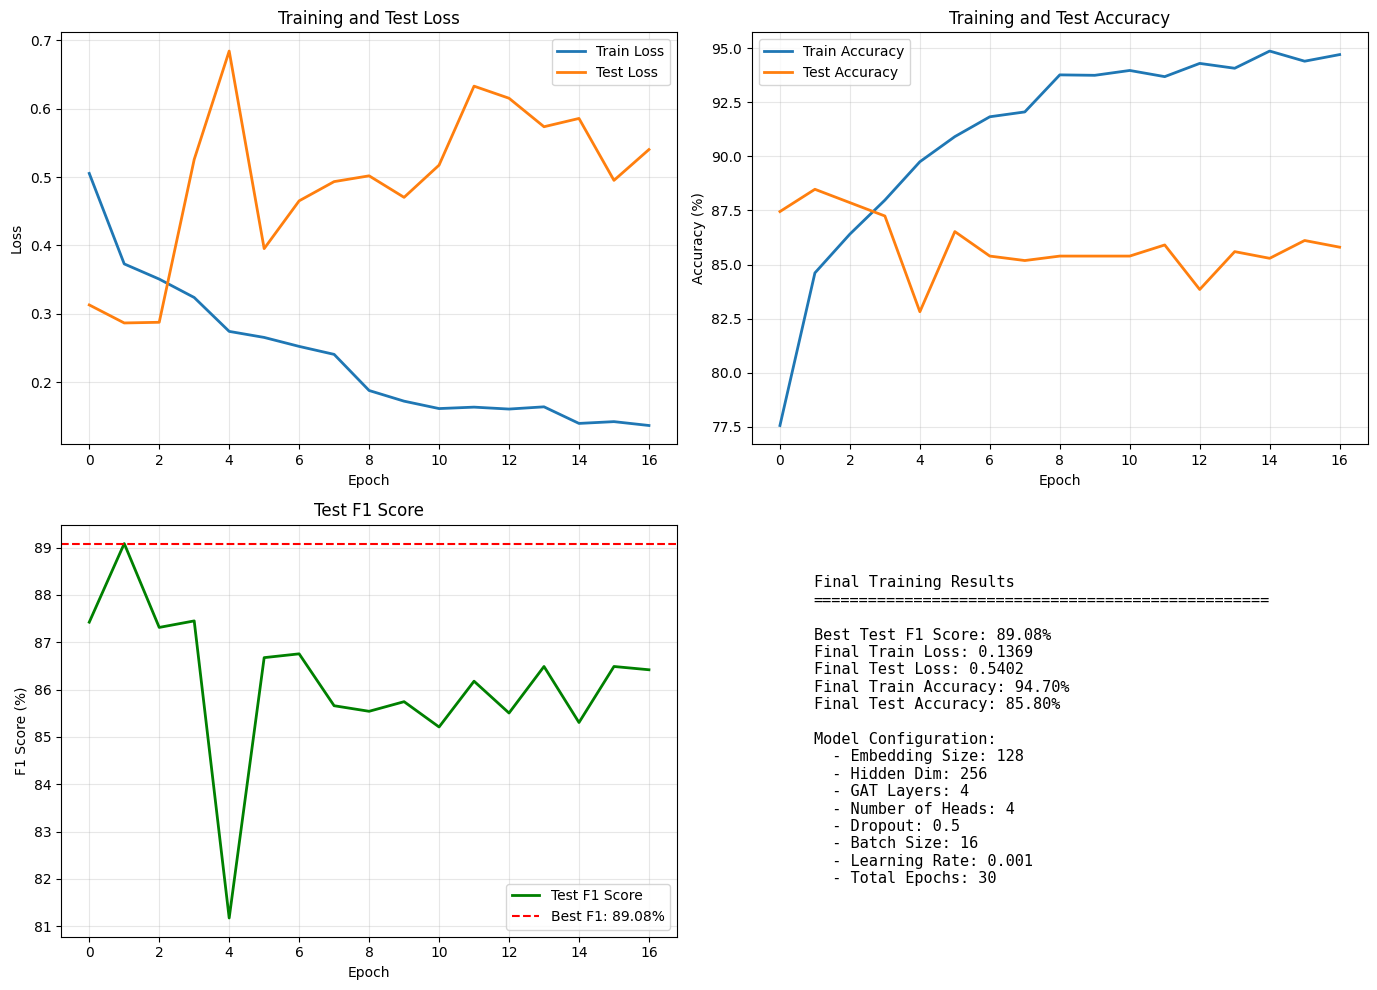

In [ ]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0, 0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy curves
axes[0, 1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[0, 1].plot(test_accs, label='Test Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Test Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# F1 curve
axes[1, 0].plot(test_f1s, label='Test F1 Score', linewidth=2, color='green')
axes[1, 0].axhline(y=best_test_f1, color='r', linestyle='--', label=f'Best F1: {best_test_f1:.2f}%')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score (%)')
axes[1, 0].set_title('Test F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Summary statistics
axes[1, 1].axis('off')
summary_text = f"""
Final Training Results
{'='*50}

Best Test F1 Score: {best_test_f1:.2f}%
Final Train Loss: {train_losses[-1]:.4f}
Final Test Loss: {test_losses[-1]:.4f}
Final Train Accuracy: {train_accs[-1]:.2f}%
Final Test Accuracy: {test_accs[-1]:.2f}%

Model Configuration:
  - Embedding Size: {EMBEDDING_SIZE}
  - Hidden Dim: {HIDDEN_DIM}
  - GAT Layers: {NUM_LAYERS}
  - Number of Heads: {NUM_HEADS}
  - Dropout: {DROPOUT}
  - Batch Size: {BATCH_SIZE}
  - Learning Rate: {LEARNING_RATE}
  - Total Epochs: {NUM_EPOCHS}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'training_curves_GAT.png'), dpi=150, bbox_inches='tight')
plt.show()

## 7. Final Evaluation on Test Set

In [16]:
# Final evaluation with best model
print("Evaluating best model on test set...\n")
final_metrics = evaluate(model, test_loader, criterion, device)

print("="*70)
print("FINAL TEST SET RESULTS")
print("="*70)
print(f"Accuracy:  {final_metrics['accuracy']:.2f}%")
print(f"Precision: {final_metrics['precision']:.2f}%")
print(f"Recall:    {final_metrics['recall']:.2f}%")
print(f"F1 Score:  {final_metrics['f1']:.2f}%")
print(f"AUC-ROC:   {final_metrics['auc']:.4f}")
print("="*70)

Evaluating best model on test set...



FINAL TEST SET RESULTS
Accuracy:  85.80%
Precision: 84.26%
Recall:    88.69%
F1 Score:  86.42%
AUC-ROC:   0.9278


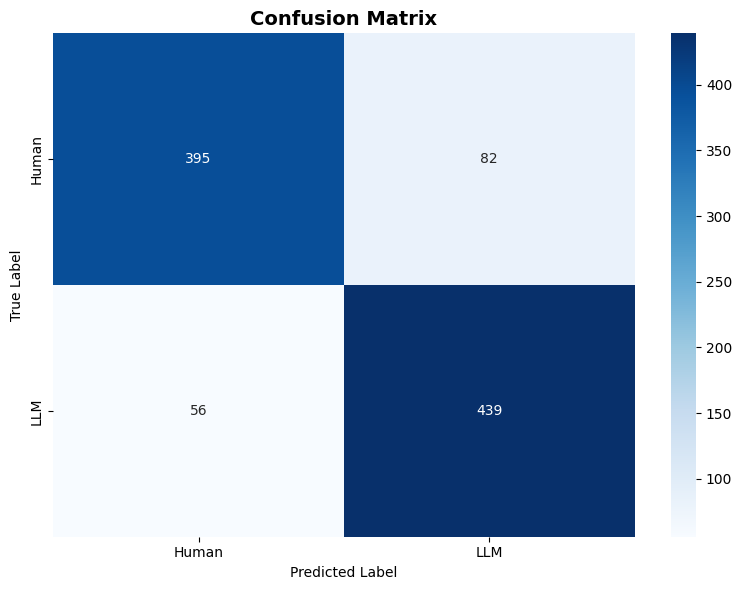


Confusion Matrix:
[[395  82]
 [ 56 439]]


In [ ]:
# Confusion matrix
cm = confusion_matrix(final_metrics['labels'], final_metrics['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Human', 'LLM'],
            yticklabels=['Human', 'LLM'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix_GAT.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix:")
print(cm)

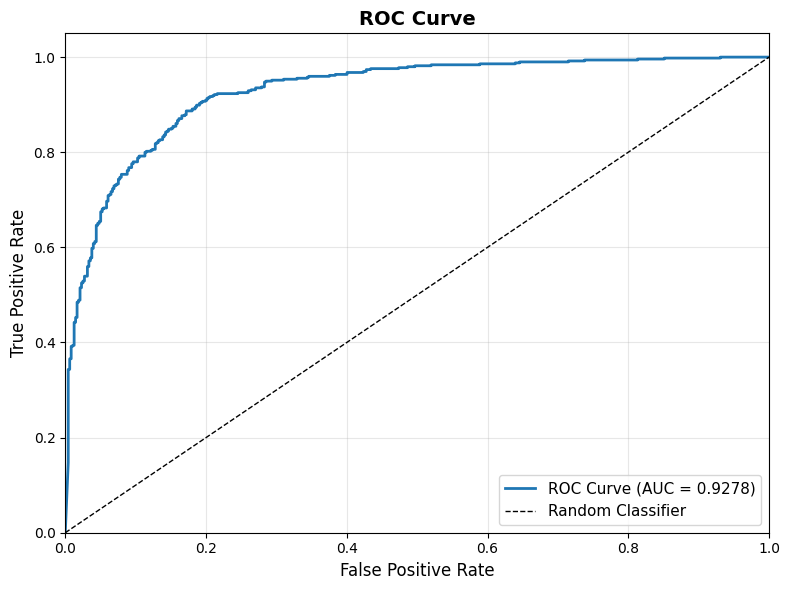

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(final_metrics['labels'], final_metrics['probabilities'])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {final_metrics["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'roc_curve_GAT.png'), dpi=150, bbox_inches='tight')
plt.show()

## 8. Error Analysis

In [19]:
# Analyze misclassifications
predictions = np.array(final_metrics['predictions'])
labels = np.array(final_metrics['labels'])
probabilities = np.array(final_metrics['probabilities'])

# Find misclassified samples
misclassified_idx = np.where(predictions != labels)[0]
correct_idx = np.where(predictions == labels)[0]

print(f"Total samples: {len(labels)}")
print(f"Correctly classified: {len(correct_idx)} ({100*len(correct_idx)/len(labels):.2f}%)")
print(f"Misclassified: {len(misclassified_idx)} ({100*len(misclassified_idx)/len(labels):.2f}%)")

# Breakdown by class
human_misclassified = np.where((predictions != labels) & (labels == 0))[0]
llm_misclassified = np.where((predictions != labels) & (labels == 1))[0]

print(f"\nMisclassified breakdown:")
print(f"  Human → LLM: {len(human_misclassified)} (false positives)")
print(f"  LLM → Human: {len(llm_misclassified)} (false negatives)")

Total samples: 972
Correctly classified: 834 (85.80%)
Misclassified: 138 (14.20%)

Misclassified breakdown:
  Human → LLM: 82 (false positives)
  LLM → Human: 56 (false negatives)


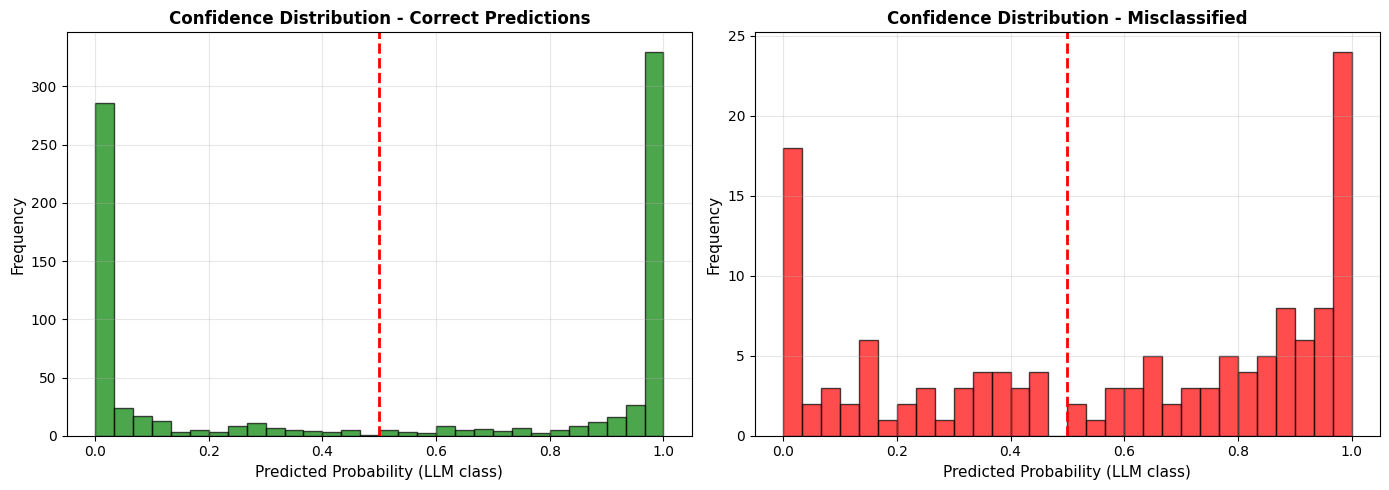

In [ ]:
# Confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence for correct predictions
correct_probs = probabilities[correct_idx]
axes[0].hist(correct_probs, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0].axvline(x=0.5, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Probability (LLM class)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Confidence Distribution - Correct Predictions', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Confidence for misclassified predictions
misclassified_probs = probabilities[misclassified_idx]
axes[1].hist(misclassified_probs, bins=30, alpha=0.7, color='red', edgecolor='black')
axes[1].axvline(x=0.5, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Probability (LLM class)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Confidence Distribution - Misclassified', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confidence_distribution_GAT.png'), dpi=150, bbox_inches='tight')
plt.show()

## 9. Model Saving and Summary

In [ ]:
# Save complete model checkpoint
checkpoint = {
    'model_state_dict': best_model_state,
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_SIZE,
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS,
    'max_nodes': MAX_NODES,
    'best_test_f1': best_test_f1,
    'final_metrics': final_metrics,
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accs': train_accs,
    'test_accs': test_accs,
    'test_f1s': test_f1s
}

checkpoint_path = os.path.join(RESULTS_DIR, 'checkpoint_GAT.pth')
torch.save(checkpoint, checkpoint_path)
print(f"Complete checkpoint saved to '{checkpoint_path}'")

Complete checkpoint saved to 'checkpoint_GAT.pth'


In [ ]:
# Save results summary
results_summary = {
    'model_config': {
        'embedding_size': EMBEDDING_SIZE,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'max_nodes': MAX_NODES,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS
    },
    'final_metrics': {
        'accuracy': float(final_metrics['accuracy']),
        'precision': float(final_metrics['precision']),
        'recall': float(final_metrics['recall']),
        'f1': float(final_metrics['f1']),
        'auc': float(final_metrics['auc'])
    },
    'confusion_matrix': cm.tolist(),
    'dataset_stats': {
        'train_size': len(valid_dataset),
        'test_size': len(test_dataset),
        'vocab_size': vocab_size
    }
}

results_path = os.path.join(RESULTS_DIR, 'results_summary_GAT.json')
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"Results summary saved to '{results_path}'")

Results summary saved to 'results_summary_GAT.json'


## 10. Sample Predictions

In [23]:
# Show some example predictions
num_examples = 5

print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

for i in range(min(num_examples, len(test_dataset))):
    sample = test_dataset[i]
    
    # Prepare inputs
    code_graph = sample['code_graph'].unsqueeze(0).to(device)
    contrast_graph = sample['contrast_graph'].unsqueeze(0).to(device)
    code_seq = [sample['code_sequence']]
    contrast_seq = [sample['contrast_sequence']]
    code_num_nodes = [sample['code_num_nodes']]
    contrast_num_nodes = [sample['contrast_num_nodes']]
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        logits = model(code_seq, code_graph, code_num_nodes,
                      contrast_seq, contrast_graph, contrast_num_nodes)
        probs = F.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1).item()
        confidence = probs[0][pred].item()
    
    true_label = sample['label'].item()
    
    print(f"\nSample {i+1}:")
    print(f"  Index: {sample['index']}")
    print(f"  True Label: {true_label} ({'Human' if true_label == 0 else 'LLM'})")
    print(f"  Predicted: {pred} ({'Human' if pred == 0 else 'LLM'})")
    print(f"  Confidence: {confidence*100:.2f}%")
    print(f"  Code nodes: {sample['code_num_nodes']}, Contrast nodes: {sample['contrast_num_nodes']}")
    print(f"  {'✓ CORRECT' if pred == true_label else '✗ INCORRECT'}")


SAMPLE PREDICTIONS

Sample 1:
  Index: gp333488
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 100.00%
  Code nodes: 15, Contrast nodes: 32
  ✓ CORRECT

Sample 2:
  Index: gp254519
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 99.98%
  Code nodes: 8, Contrast nodes: 24
  ✓ CORRECT

Sample 3:
  Index: gp320381
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 99.99%
  Code nodes: 114, Contrast nodes: 128
  ✓ CORRECT

Sample 4:
  Index: gp162698
  True Label: 0 (Human)
  Predicted: 0 (Human)
  Confidence: 90.11%
  Code nodes: 45, Contrast nodes: 47
  ✓ CORRECT

Sample 5:
  Index: gp187093
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 99.66%
  Code nodes: 7, Contrast nodes: 32
  ✓ CORRECT
